In [73]:
using Pkg
Pkg.activate(".")

using Revise, PtyLab, TestImages, ImageShow, IndexFunArrays, FFTW, HDF5, Noise, FourierTools, CUDA
using EllipsisNotation, NDTools
FFTW.forget_wisdom()
FFTW.set_num_threads(4)

  Activating project at `~/.julia/dev/PtyLab.jl/examples`


## Object

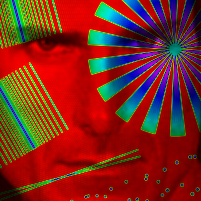

In [13]:
img_abs = Float32.(testimage("fabio_gray_512"))[200:400, 200:400]
img_phase = Float32.(testimage("resolution_test_512"))[200:400, 200:400]
object = img_abs .* cispi.(2 .* img_phase)

simshow(object)

## Random Grid

grr.overlap = (0.86, 0.86)


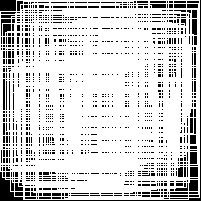

In [14]:
grid_size = size(object)
tile_size = (100, 100)

grr = PtyLab.grid_regular_rand(grid_size, tile_size, (15, 15), 30);
@show grr.overlap
show_grid(grr, only_points=false)

## Probe

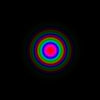

In [15]:
probe = IndexFunArrays.gaussian(Float32, tile_size, scale=0.010) .* cis.(Float32(2π) .* 
     4 .* gaussian(Float32, tile_size, scale=0.003));

simshow(probe)

## Simulate and store as dataset

In [16]:
ptychogram = zeros(Float32, (tile_size..., length(grr.tiles)));
p = Params()
o2d, d2o = Fraunhofer(probe, fftshiftSwitch=true);

for (i, t) in enumerate(grr.tiles)
    ptychogram[:, :, i] = poisson(abs2.(o2d(view(object, t.i₁:t.i₂,  t.j₁:t.j₂) .* probe)), 1000)
end


lambda = 633f-9
z = 50f-3
dxd = 10f-6
Nd = size(ptychogram, 1)
dxo = lambda * z / (Nd * dxd)

fid_new = h5open("simulated_ptychography.hdf5", "w");
fid_new["Nd"] = Nd
fid_new["No"] = size(img_abs, 1)
fid_new["dxd"] = 10f-6
fid_new["encoder"] = PtyLab.encoder(grr, dxo, offset=(50, 50))
fid_new["wavelength"] = lambda
fid_new["entrancePupilDiameter"] = dxo * 30
fid_new["zo"] = z
fid_new["ptychogram"] = ptychogram
close(fid_new)
#@view_image ptychogram;

## Load dataset again

In [129]:
experimentalData = ExperimentalDataCPM("simulated_ptychography.hdf5");
reconstruction = ReconstructionCPM(experimentalData, cuda=false);

[ Info: Reading HDF5.File: (read-only) simulated_ptychography.hdf5 was successful
┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/utils_calc.jl:91


### On CPU

In [150]:
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

params2 = Params(fftshiftSwitch = false, transposePtychogram = false, 
                 comStabilizationSwitch = true, probePowerCorrectionSwitch=true)

engine = PtyLab.mPIE(betaProbe=0.75f0, betaObject=0.75f0, numIterations = 100)

PtyLab.mPIE{Float32}
  numIterations: Int64 100
  betaProbe: Float32 0.75f0
  betaObject: Float32 0.75f0
  alphaProbe: Float32 0.1f0
  alphaObject: Float32 0.1f0
  feedbackM: Float32 0.3f0
  frictionM: Float32 0.7f0


In [151]:
@time p, o = PtyLab.reconstruct(engine, params2, reconstruction);

┌ Warning: gimmel is currently estimated as `eps(Float32)`
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/Engines.jl:79
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.332017 seconds (5.22 M allocations: 3.339 GiB, 0.93% gc time)


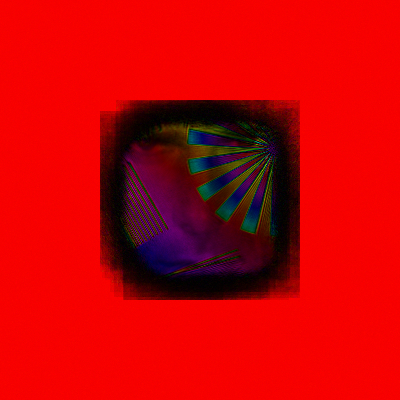

In [154]:
simshow(select_regiono[:, :, 1,1,1,1])

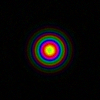

In [153]:
simshow(p[:, :, 1,1,1,1])